<a href="https://colab.research.google.com/github/Hosein-Ghojavand/Farsi-English-SMS-Spam-Detection/blob/main/English_sms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install URLExtract

In [ ]:
# Standard Library Imports
import re
import warnings

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Text Processing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from urlextract import URLExtract
from tqdm import tqdm

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Suppressing Warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP Files/spam.csv", encoding='latin1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

In [ ]:
# drop last 3 columns; which are not usefull
df = df[["v1","v2"]]

In [ ]:
# rename columns names
df.rename(columns={"v1":"Class", "v2":"Text"}, inplace=True)

In [ ]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

Found duplicate rows. Removing them...


In [ ]:
# Check for missing values
missing_values = df.isna().sum()
if missing_values.any():
    print("Found missing values. Removing them...")
    df = df.dropna()

In [ ]:
df.shape

(5169, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5169 non-null   object
 1   Text    5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [ ]:
# adding some usfule columns to the dataset

# number of words in a message
df['NO_words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))

# number of characters in a message
df['NO_characters'] = df['Text'].apply(len)

# number of sentence in message
df['NO_sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [ ]:
df.head()

,Class,Text,NO_words,NO_characters,NO_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",24,111,2
1,ham,Ok lar... Joking wif u oni...,8,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,37,155,2
3,ham,U dun say so early hor... U c already then say...,13,49,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",15,61,1


In [ ]:
# Descriptive statistics of text features
df.describe()

,NO_words,NO_characters,NO_sentences
count,5169.000000,5169.000000,5169.000000
mean,18.455794,78.977945,1.965564
std,13.324758,58.236293,1.448541
min,1.000000,2.000000,1.000000
25%,9.000000,36.000000,1.000000
50%,15.000000,60.000000,1.000000
75%,26.000000,117.000000,2.000000
max,220.000000,910.000000,38.000000


In [ ]:
# Descriptive statistics of text features for HAM messages
df[df['Class'] == "ham"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
# Descriptive statistics of text features for SPAM messages
df[df['Class'] == "spam"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


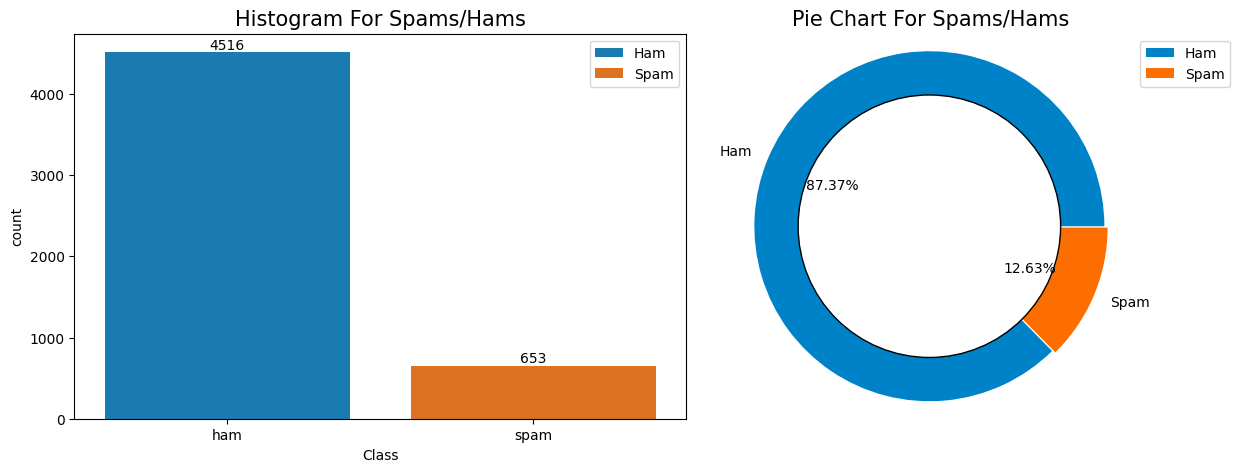

In [ ]:
# Calculate number of each class (ham or spam)
spam_count = df['Class'].value_counts()['spam']
ham_count = df['Class'].value_counts()['ham']

# Color settings
hist_colors = ['#0082c8', '#fc6e00']
pie_colors = ['#0082c8', '#fc6e00']

# Plotting
labels = ['Ham', 'Spam']
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', hue='Class', alpha=1, palette=hist_colors)
plt.legend(labels)
plt.title('Histogram For Spams/Hams', size=15)

# Annotate histogram with exact counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Pie Chart
plt.subplot(1, 2, 2)
sizes = [ham_count, spam_count]
explode = [0, 0.02]
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', colors=pie_colors)
plt.axis('equal')
plt.legend(labels)
circle = plt.Circle(xy=(0, 0), radius=0.75, facecolor='white', edgecolor='black')
plt.gca().add_artist(circle)
plt.title('Pie Chart For Spams/Hams', size=15)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(wspace= -0.1)  # Reduce the value to bring plots closer

# # Save the plot with higher quality
# plt.savefig('Spam_vs_Ham_distribution_high_quality.png', format='png', dpi=1000)

plt.show()


### "The dataset is heavily imbalanced, with ham messages comprising 87.37% (4516 messages) and spam messages making up 12.63% (653 messages)."






.



.



.

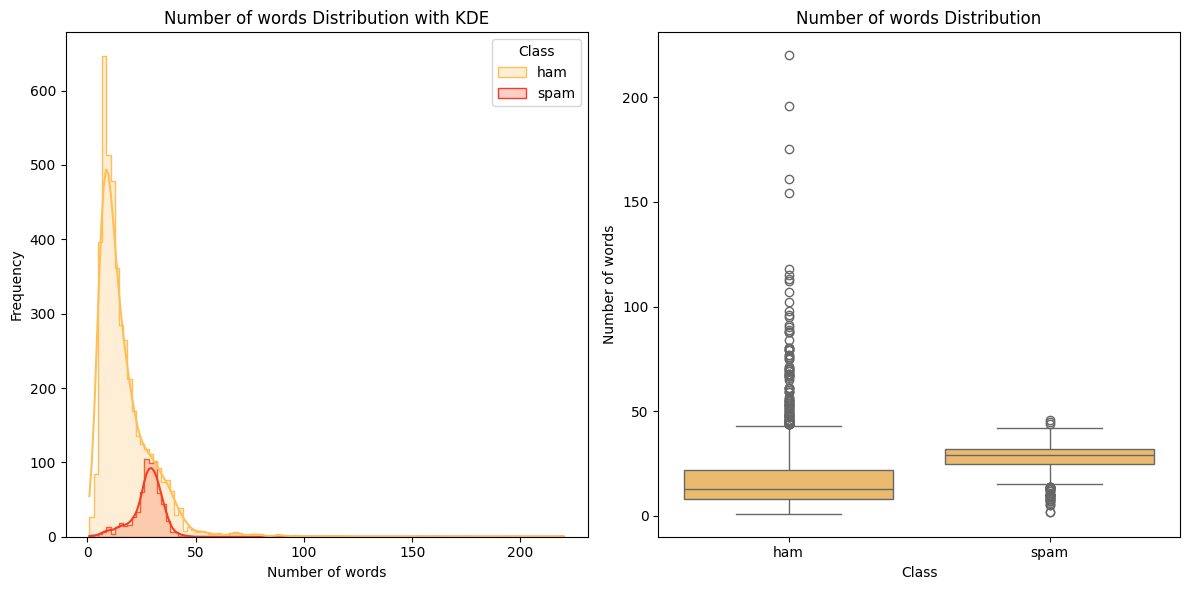

In [ ]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_words', hue='Class', kde=True, element='step')
plt.title('Number of words Distribution with KDE')
# plt.xticks(range(0, df['NO_words'].max() + 1, 10))  # Adjust the step size as needed
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_words', data=df)
plt.title('Number of words Distribution')
plt.xlabel('Class')
plt.ylabel('Number of words')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
# plt.savefig('Number of words Distribution.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The KDE plot on the left shows that the majority of ham messages contain fewer than 50 words, with a sharp peak around 5-10 words. The box plot on the right indicates that the median number of words in ham messages is around 10, with a considerable range and several outliers extending up to about 200 words.
2.	Spam Messages: The KDE plot indicates that spam messages also typically contain fewer than 50 words, but the peak is slightly higher around 10-20 words. The box plot reveals that the median number of words in spam messages is higher than that of ham, approximately around 20 words, with fewer extreme outliers compared to ham messages.
## Descriptive Sentence:
### "Ham messages generally contain fewer words, with a median of about 10 words and a significant number of outliers, indicating occasional longer messages. In contrast, spam messages have a higher median word count of around 20 words, suggesting that spam messages are typically longer but with fewer extreme outliers compared to ham."

.



.



.



.


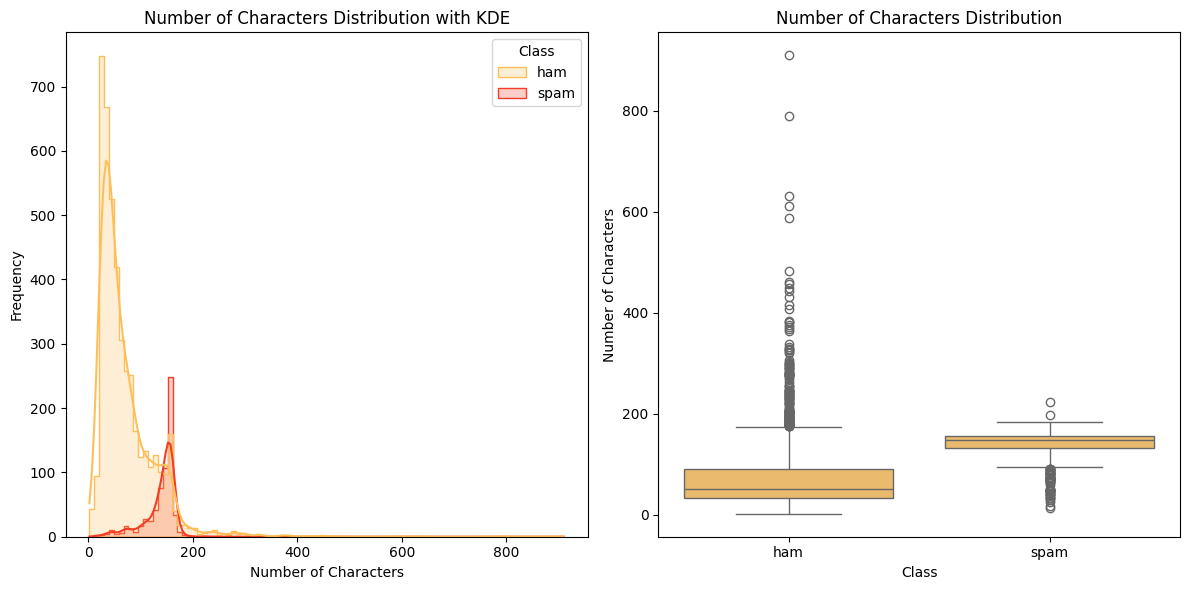

In [ ]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_characters', hue='Class', kde=True, element='step')
plt.title('Number of Characters Distribution with KDE')
# plt.xticks(range(0, df['NO_characters'].max() + 1, 50))  # Adjust the step size as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_characters', data=df)
plt.title('Number of Characters Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Characters')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
# plt.savefig('Number of Characters.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The left panel (KDE plot) demonstrates that the number of characters in ham messages typically ranges between 0 and 200, with a sharp peak around 50 characters. The right panel (box plot) shows that the median number of characters in ham messages is around 50, with a considerable number of outliers extending up to around 800 characters.
2.	Spam Messages: The KDE plot indicates that spam messages tend to have a higher number of characters compared to ham, with a peak around 150 characters. The box plot reveals that the median number of characters in spam messages is higher than that of ham, with fewer extreme outliers.
## Descriptive Sentence:
### "Spam messages tend to be longer, typically around 150 characters, compared to ham messages, which have a median length of about 50 characters. The distribution of ham messages shows more extreme outliers, indicating occasional longer messages."




.





.





.




.

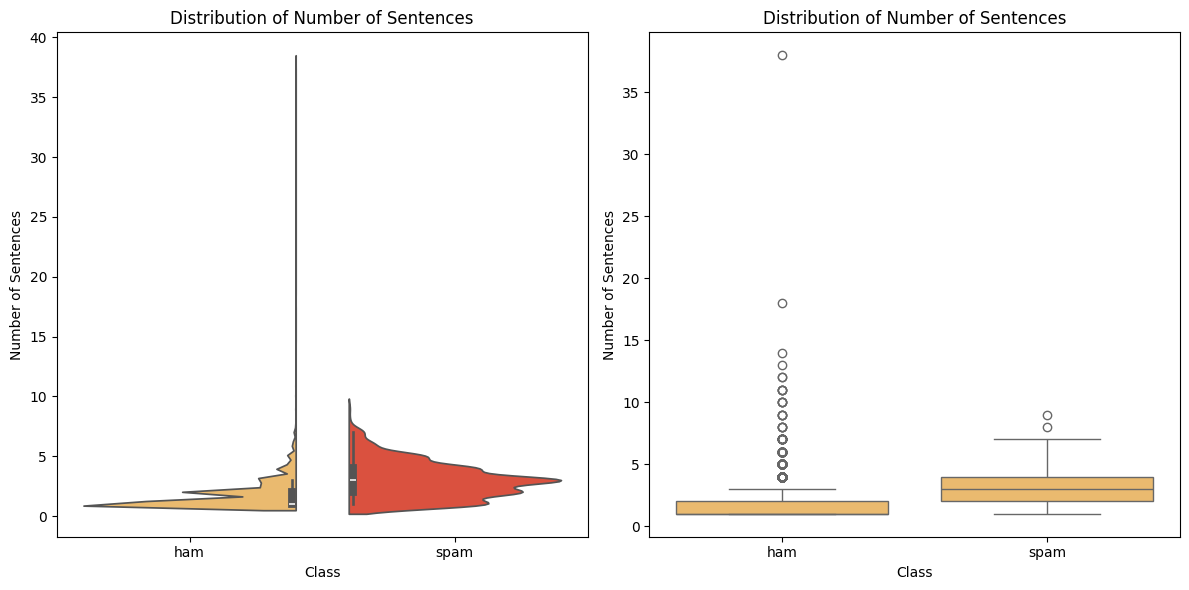

In [ ]:

plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot - Violin Plot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.violinplot(data=df, x='Class', y='NO_sentences', hue='Class', split=True)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Second subplot - Box Plot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_sentences', data=df)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
# plt.savefig('Number of sentenc.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The left panel (distribution plot) shows that the majority of ham (non-spam) messages have a low number of sentences, mostly between 1 and 5. The right panel (box plot) indicates that the median number of sentences in ham messages is around 1, with a few outliers having a higher number of sentences.
2.	Spam Messages: The distribution plot indicates that spam messages also tend to have a low number of sentences, but there is a slightly higher concentration around 1 to 2 sentences compared to ham. The box plot shows that the median number of sentences in spam messages is also around 1, but with fewer outliers compared to ham.
## Descriptive Sentence:
### "Most ham and spam messages contain only 1 to 2 sentences, indicating that both types of messages are generally concise. However, ham messages show more variability and outliers, suggesting that they occasionally contain more detailed content."


.




.




.




.

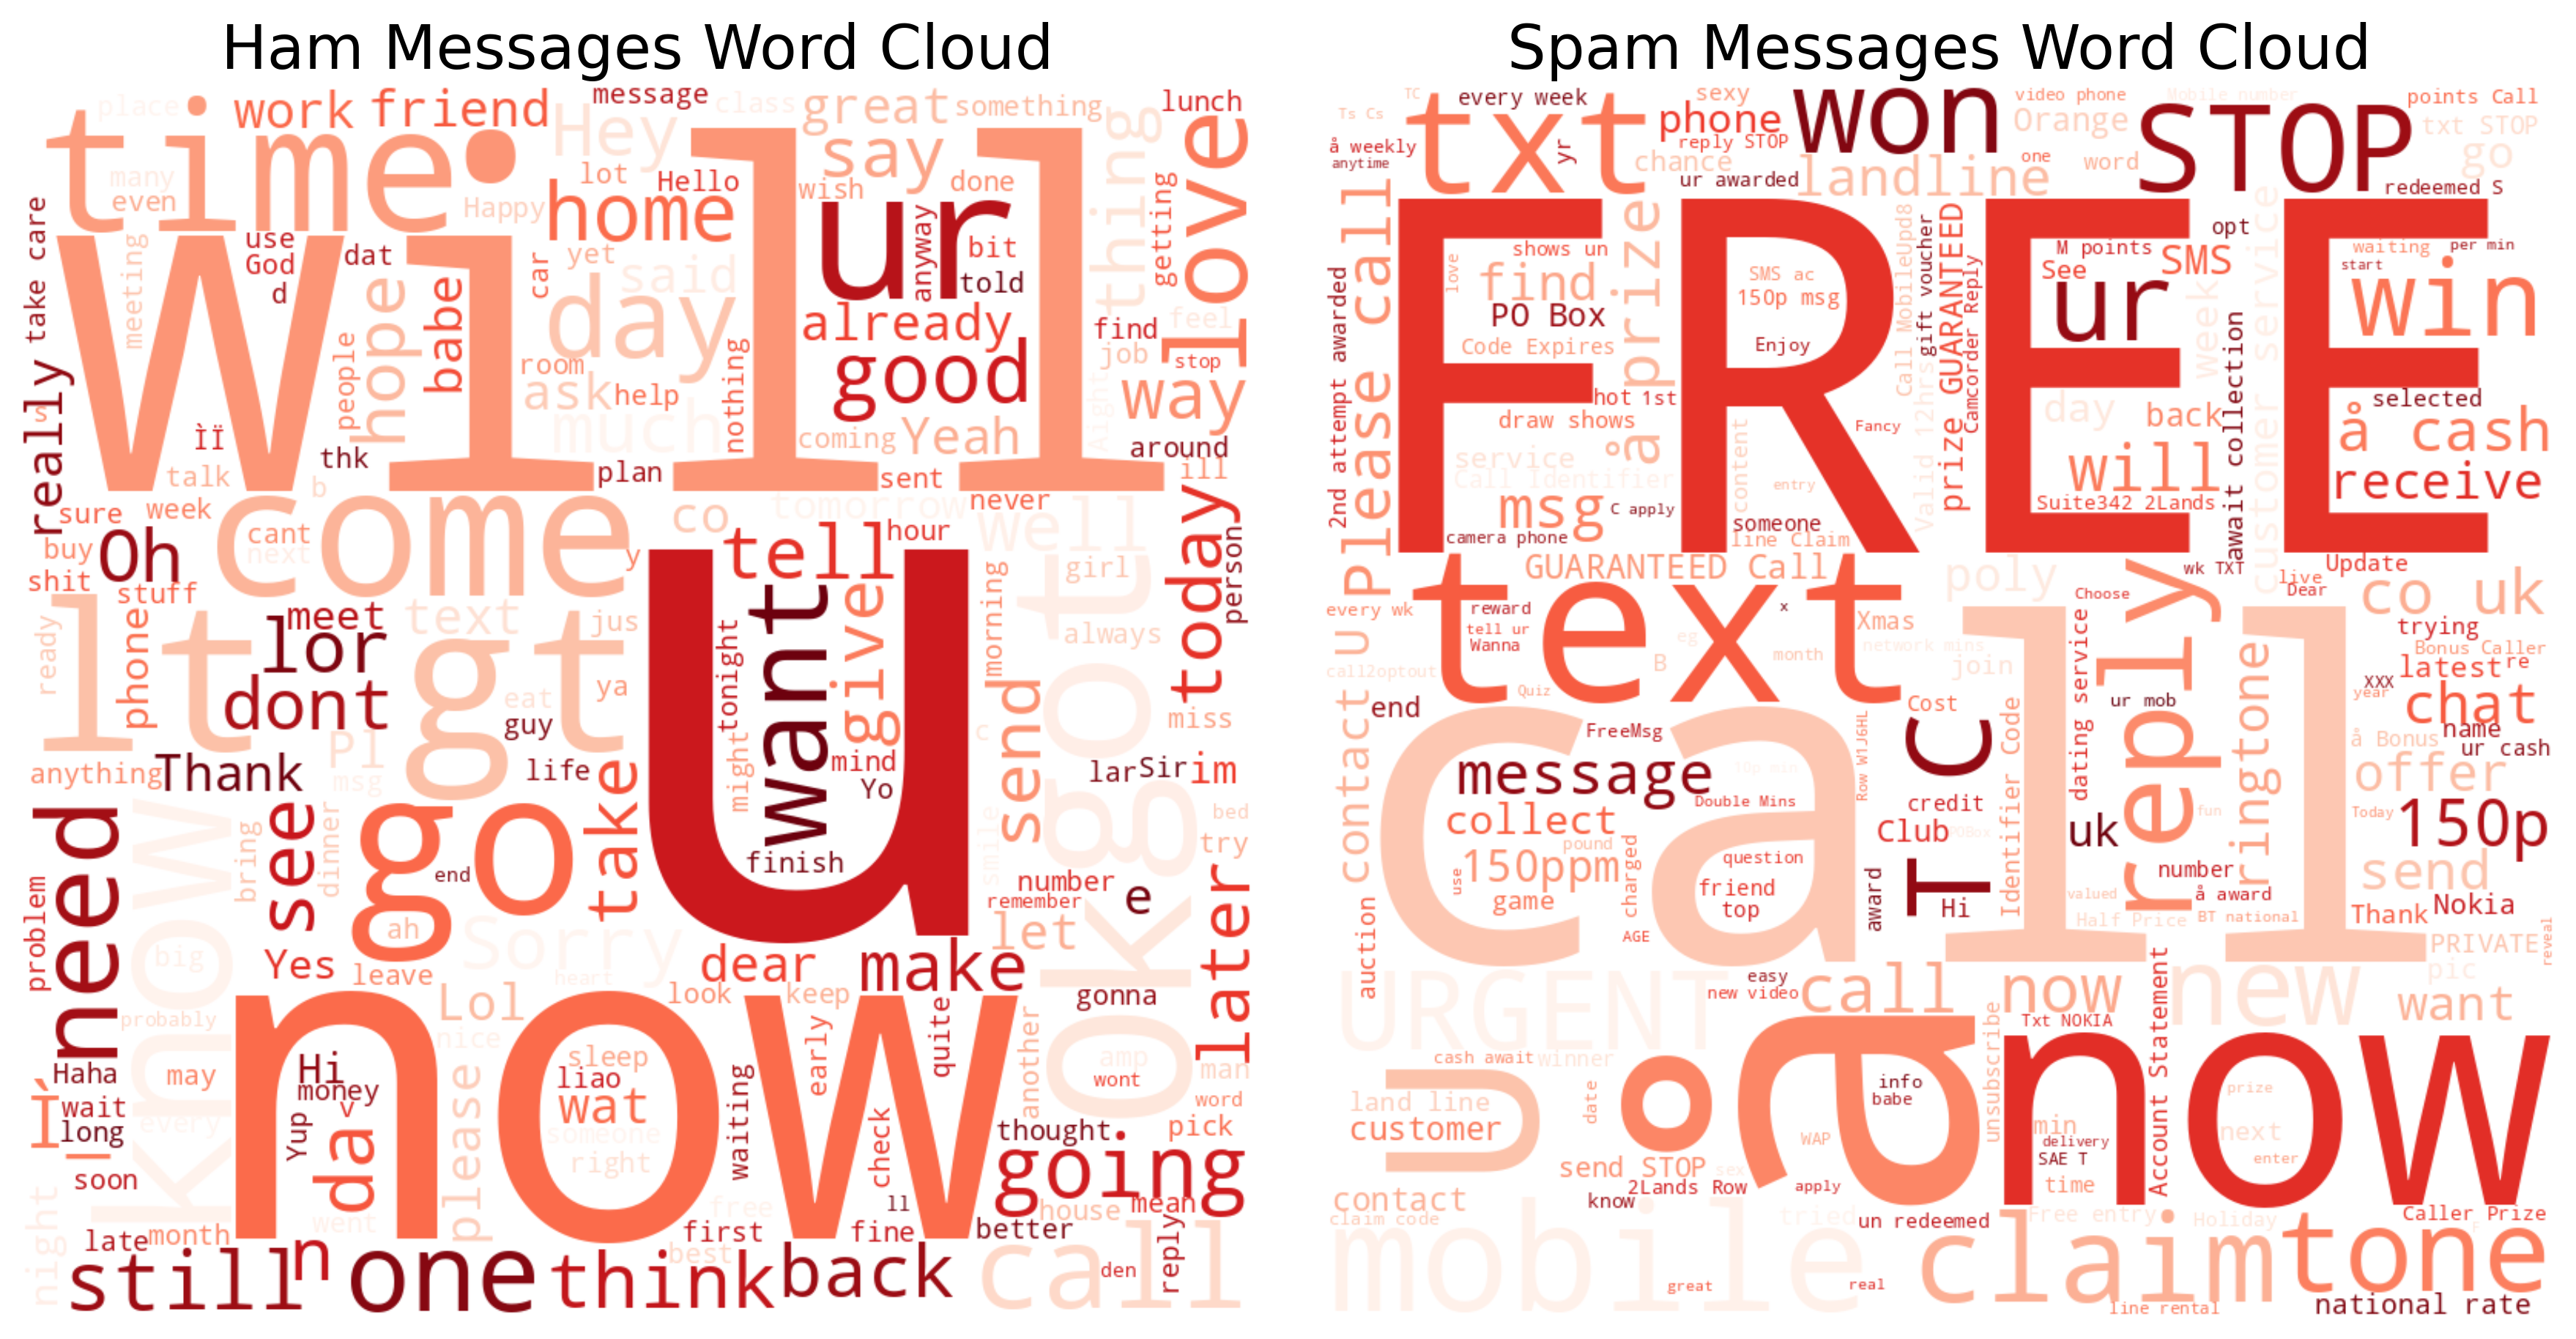

In [ ]:
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))


ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()


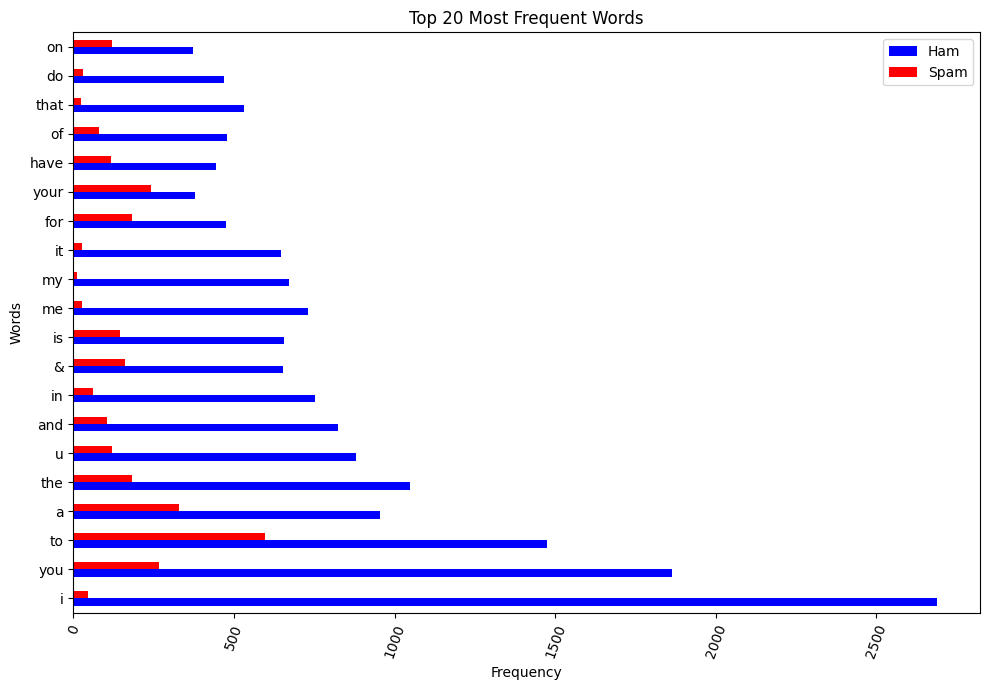

In [ ]:

# Function to clean and tokenize the text for English
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    unwanted_patterns = r'[\/:?\.\,;!"]|^\d+$|^(https?|www)$'
    tokens = [token for token in tokens if not re.match(unwanted_patterns, token)]
    return tokens

# Prepare and clean text
ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))
ham_words = clean_and_tokenize(ham_text)
spam_words = clean_and_tokenize(spam_text)

# Calculate term frequency and combine into a single DataFrame
ham_word_counts = pd.Series(ham_words).value_counts()
spam_word_counts = pd.Series(spam_words).value_counts()
combined_word_counts = pd.DataFrame({'Ham': ham_word_counts, 'Spam': spam_word_counts}).fillna(0)

# Calculate the total frequency for sorting
combined_word_counts['Total'] = combined_word_counts.sum(axis=1)

# Sort the DataFrame by total frequency
combined_word_counts = combined_word_counts.sort_values(by='Total', ascending=False)

# Get the top 20 most frequent words
top_words = combined_word_counts.head(20)

# Drop the 'Total' column after sorting
top_words = top_words.drop(columns='Total')

# Plot term frequency bar chart for the top 20 most frequent words
fig, ax = plt.subplots(figsize=(10, 7))

top_words.plot(kind='barh', ax=ax, color=['blue', 'red'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=70, ha='center')

plt.tight_layout()
plt.show()

### Let's define some functions for preprocessing.

In [ ]:
def remove_urls(text):
    """Replaces URLs in the text with <URL>."""
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "<URL>")
    return text

def normalize_text(text):
    """Normalizes the text: lowercasing, removing punctuation."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text
# ***** remember that you should make the puntuation handeling integerated. ****
def handle_punctuation(text):
    """Handles punctuation by removing unwanted characters."""
    unwanted_patterns = r'[\/:?\.\,;!\"\'()-]'
    return re.sub(unwanted_patterns, '', text)

def tokenize_text(text):
    """Tokenizes the text using NLTK word tokenizer."""
    return word_tokenize(text)

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def remove_stopwords(tokens):
    """Removes stopwords from the list of tokens."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def join_tokens(tokens):
    """Joins the list of tokens back into a sentence."""
    return ' '.join(tokens)

### next, I'll preprocess each step separately, using progress bars to track each one. After completing each step, I'll save the changes to a separate CSV file, so if the process stops unexpectedly, I can resume from the last completed step without starting over.

In [ ]:
tqdm.pandas()

# Step 1: Remove URLs
print("Removing URLs......")
df['Text'] = df['Text'].progress_apply(remove_urls)
df.to_csv('step1_removed_urls.csv', index=False)

# Step 2: Normalize text
print("Normalizing text.......")
df['Text'] = df['Text'].progress_apply(normalize_text)
df.to_csv('step2_normalized_text.csv', index=False)

# Step 3: Handle punctuation
print("Handling punctuation.......")
df['Text'] = df['Text'].progress_apply(handle_punctuation)
df.to_csv('step4_handled_punctuation.csv', index=False)

# Step 4: Tokenize text
print("Tokenizing text.......")
df['Tokens'] = df['Text'].progress_apply(tokenize_text)
df.to_csv('step5_tokenized_text.csv', index=False)

# Step 5: Lemmatize tokens
print("Lemmatizing tokens.......")
df['Tokens'] = df['Tokens'].progress_apply(lemmatize_tokens)
df.to_csv('step6_lemmatized_tokens.csv', index=False)

# Step 6: Remove stopwords
print("Removing stopwords.......")
df['Tokens'] = df['Tokens'].progress_apply(remove_stopwords)
df.to_csv('step7_removed_stopwords.csv', index=False)

# Step 7: Join tokens back into a sentence
print("Joining tokens back into a sentence.......")
df['Text'] = df['Tokens'].progress_apply(join_tokens)
df.to_csv('final_preprocessed_dataset.csv', index=False)

print("Preprocessing complete and saved at each step.")

Removing URLs......


100%|██████████| 5169/5169 [02:27<00:00, 35.03it/s]


Normalizing text.......


100%|██████████| 5169/5169 [00:00<00:00, 201822.30it/s]


Handling punctuation.......


100%|██████████| 5169/5169 [00:00<00:00, 362553.84it/s]


Tokenizing text.......


100%|██████████| 5169/5169 [00:00<00:00, 8014.89it/s]


Lemmatizing tokens.......


100%|██████████| 5169/5169 [00:01<00:00, 2788.95it/s]


Removing stopwords.......


100%|██████████| 5169/5169 [00:01<00:00, 4871.21it/s]


Joining tokens back into a sentence.......


100%|██████████| 5169/5169 [00:00<00:00, 380210.40it/s]

Preprocessing complete and saved at each step.


In [ ]:
# Load the latest preprocessed CSV file::
df = pd.read_csv("/content/final_preprocessed_dataset.csv", encoding='UTF-8')

In [ ]:
df

,Class,Text,NO_words,NO_characters,NO_sentences,Tokens
0,ham,go jurong point crazi avail onli bugi n great ...,24,111,2,"['go', 'jurong', 'point', 'crazi', 'avail', 'o..."
1,ham,ok lar joke wif u oni,8,29,2,"['ok', 'lar', 'joke', 'wif', 'u', 'oni']"
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,37,155,2,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,ham,u dun say earli hor u c alreadi say,13,49,1,"['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', ..."
4,ham,nah dont think goe usf live around though,15,61,1,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...,...,...,...,...,...
5164,spam,thi 2nd time tri 2 contact u u å750 pound priz...,35,161,4,"['thi', '2nd', 'time', 'tri', '2', 'contact', ..."
5165,ham,ì_ b go esplanad fr home,9,37,1,"['ì_', 'b', 'go', 'esplanad', 'fr', 'home']"
5166,ham,piti wa mood soani suggest,15,57,2,"['piti', 'wa', 'mood', 'soani', 'suggest']"
5167,ham,guy bitch act like id interest buy someth els ...,27,125,1,"['guy', 'bitch', 'act', 'like', 'id', 'interes..."


In [ ]:
# Replace text labels 'ham' and 'spam' with 0 and 1 in the 'Class' column
df["Class"].replace({"ham": 0, "spam": 1}, inplace=True)

In [ ]:
# Drop rows with missing values in the 'Text' column
df = df.dropna(subset=['Text'])

# Text Vectorization using TF-IDF for the 'Text' Column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['Text'])
Y = df["Class"]


In [ ]:
# Splitting data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

In [ ]:
# Classifier models
svm = SVC(kernel='sigmoid', gamma=1.0)
knn = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear', penalty='l2')
rf = RandomForestClassifier(n_estimators=50, random_state=2)
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
bagging = BaggingClassifier(n_estimators=50, random_state=2)
et = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [ ]:
models = {
    'SVM': svm,
    'KNN': knn,
    'MultinomialNB': mnb,
    # 'GaussianNB': gnb,
    # 'BernoulliNB': bnb,
    'DT': dt,
    'LR': lr,
    'RF': rf,
    'AdaBoost': ada,
    'Bagging': bagging,
    'ExtraTrees': et,
    'GBDT': gbdt,
    'XGB': xgb
}

In [ ]:
# Function to train classifiers and evaluate performance
def train_classifier(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    return accuracy, precision, recall, f1, y_pred


For SVM
Accuracy: 0.9748305905130688
Precision: 0.9719626168224299
Recall: 0.8188976377952756
F1 Score: 0.8888888888888888


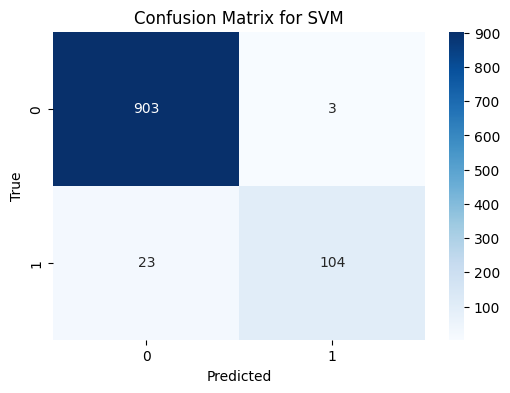


For KNN
Accuracy: 0.9506292352371732
Precision: 0.9871794871794872
Recall: 0.6062992125984252
F1 Score: 0.751219512195122


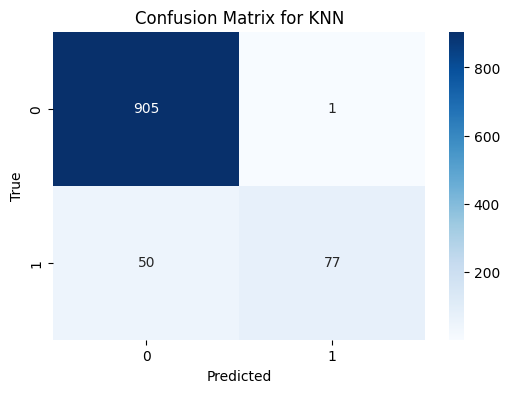


For MultinomialNB
Accuracy: 0.9351403678606002
Precision: 1.0
Recall: 0.47244094488188976
F1 Score: 0.6417112299465241


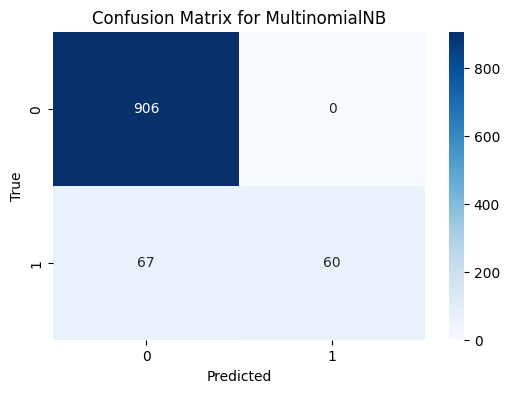


For DT
Accuracy: 0.9351403678606002
Precision: 0.7941176470588235
Recall: 0.6377952755905512
F1 Score: 0.7074235807860262


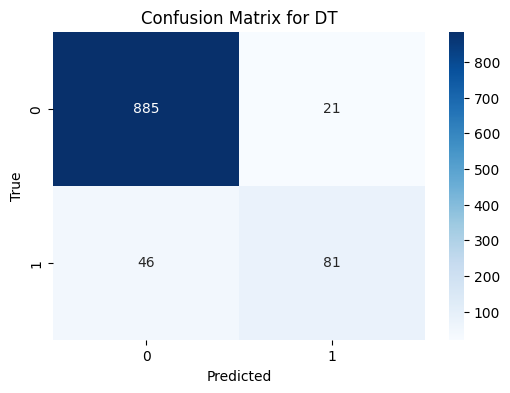


For LR
Accuracy: 0.9283639883833494
Precision: 0.9649122807017544
Recall: 0.4330708661417323
F1 Score: 0.5978260869565217


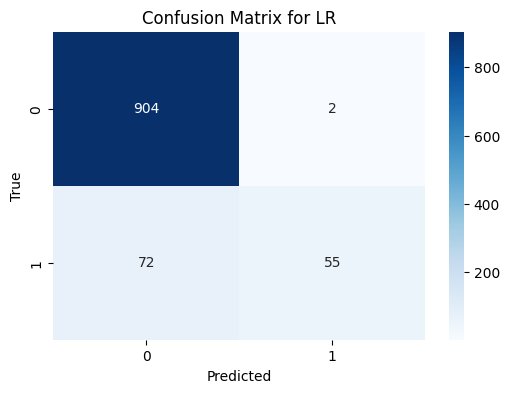


For RF
Accuracy: 0.9670861568247822
Precision: 1.0
Recall: 0.7322834645669292
F1 Score: 0.8454545454545455


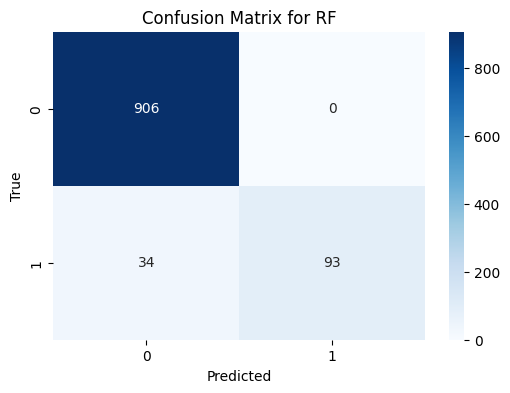


For AdaBoost
Accuracy: 0.9622458857696031
Precision: 0.8928571428571429
Recall: 0.7874015748031497
F1 Score: 0.8368200836820083


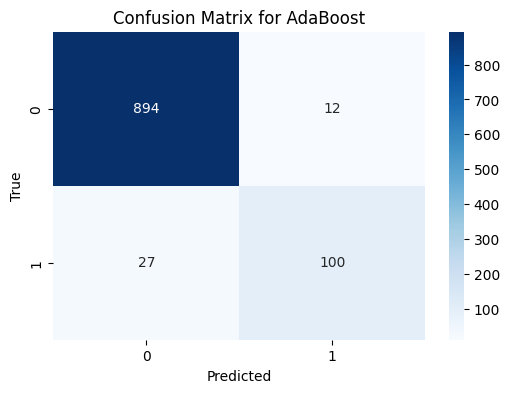


For Bagging
Accuracy: 0.957405614714424
Precision: 0.8487394957983193
Recall: 0.7952755905511811
F1 Score: 0.8211382113821138


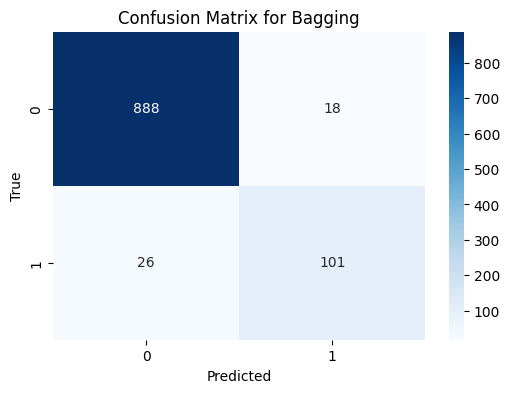


For ExtraTrees
Accuracy: 0.9670861568247822
Precision: 1.0
Recall: 0.7322834645669292
F1 Score: 0.8454545454545455


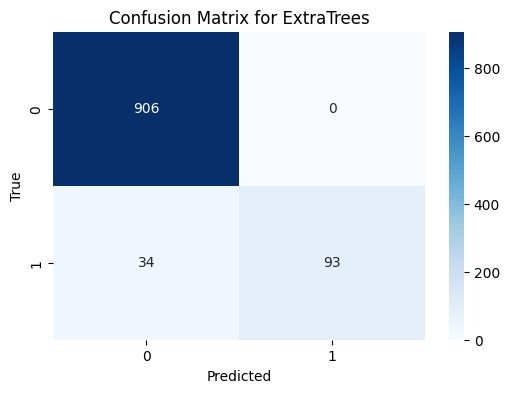


For GBDT
Accuracy: 0.952565343659245
Precision: 0.8979591836734694
Recall: 0.6929133858267716
F1 Score: 0.7822222222222223


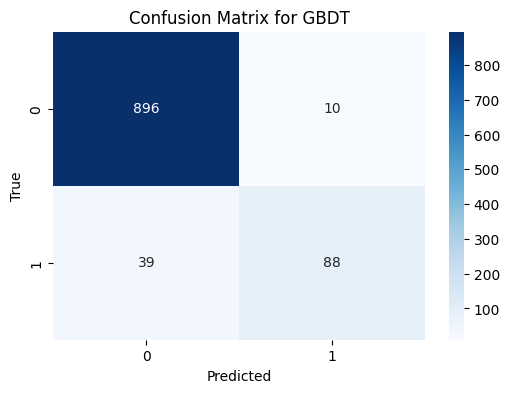


For XGB
Accuracy: 0.9690222652468539
Precision: 0.8991596638655462
Recall: 0.84251968503937
F1 Score: 0.8699186991869918


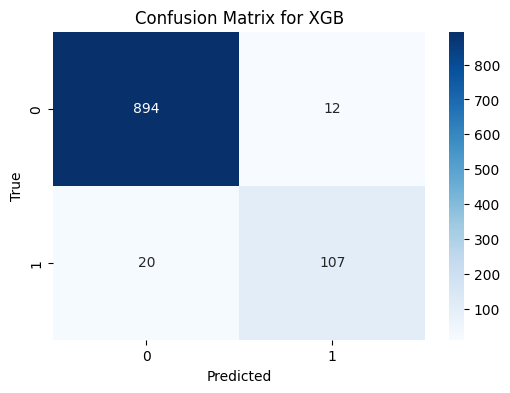

In [ ]:
# Lists to store performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Train classifiers and store their performance
for name, model in models.items():
    accuracy, precision, recall, f1, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
    print(f"\nFor {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Plot confusion matrix for each classifier
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Create a DataFrame to store and compare the accuracy, precision, recall, and F1 scores of the different algorithms
performance_df = pd.DataFrame({
    'Algorithm': list(models.keys()),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

In [ ]:
# Sort the DataFrame by 'F1 Score' in descending order
performance_df = performance_df.sort_values('F1 Score', ascending=False)

# Reset the index to ensure it is sequential
performance_df = performance_df.reset_index(drop=True)

performance_df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,SVM,0.974831,0.971963,0.818898,0.888889
1,XGB,0.969022,0.899160,0.842520,0.869919
2,RF,0.967086,1.000000,0.732283,0.845455
3,ExtraTrees,0.967086,1.000000,0.732283,0.845455
4,AdaBoost,0.962246,0.892857,0.787402,0.836820
5,Bagging,0.957406,0.848739,0.795276,0.821138
6,GBDT,0.952565,0.897959,0.692913,0.782222
7,KNN,0.950629,0.987179,0.606299,0.751220
8,DT,0.935140,0.794118,0.637795,0.707424
9,MultinomialNB,0.935140,1.000000,0.472441,0.641711
